# Import Required Libraries
Import libraries such as NumPy, pandas, and matplotlib for numerical computations, data handling, and visualization.

In [497]:
# Import necessary libraries for numerical computations, data handling, and visualization
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Define Interest Rate Swap Parameters
Define parameters for the interest rate swap, including notional amount, fixed rate, floating rate index, and maturity.

In [498]:
# Define parameters for the interest rate swap
notional_amount = 1000000  # Notional amount in EUR
fixed_rate = 0.023661585  # Fixed rate (today's rate)
floating_rate_index = "ESTR"  # Floating rate index
maturity_years = 5  # Maturity in years
payment_frequency = 3/12 # Quarterly payments

# Display the defined parameters
print("Interest Rate Swap Parameters:")
print(f"Notional Amount: ${notional_amount}")
print(f"Fixed Rate: {fixed_rate * 100}%")
print(f"Floating Rate Index: {floating_rate_index}")
print(f"Maturity: {maturity_years} years")
print(f"Payment Frequency: every {int(payment_frequency*12)} months")

Interest Rate Swap Parameters:
Notional Amount: $1000000
Fixed Rate: 2.3661585%
Floating Rate Index: ESTR
Maturity: 5 years
Payment Frequency: every 3 months


# Simulate Interest Rate Paths
The Hull-White stochastic model is used to simulate interest rate paths over time. It is defined by the following SDE : 
$$
dr(t) = [\Theta(t) - a r(t)]dt + \sigma dW(t)
$$

## Model parameters choices

In [499]:
mean_reversion_speed = 0.03 
long_term_mean_rate = 0.02  

The mean reversion speed $a$ is often based on historical data or expert based. For the long term mean, it is obtained by solving the following:

$$
\Theta (t) = \frac{\delta f(0,t)}{\delta t} + af(0,t) + \frac{\sigma ^2}{2a}(1-e^{-2at})
$$


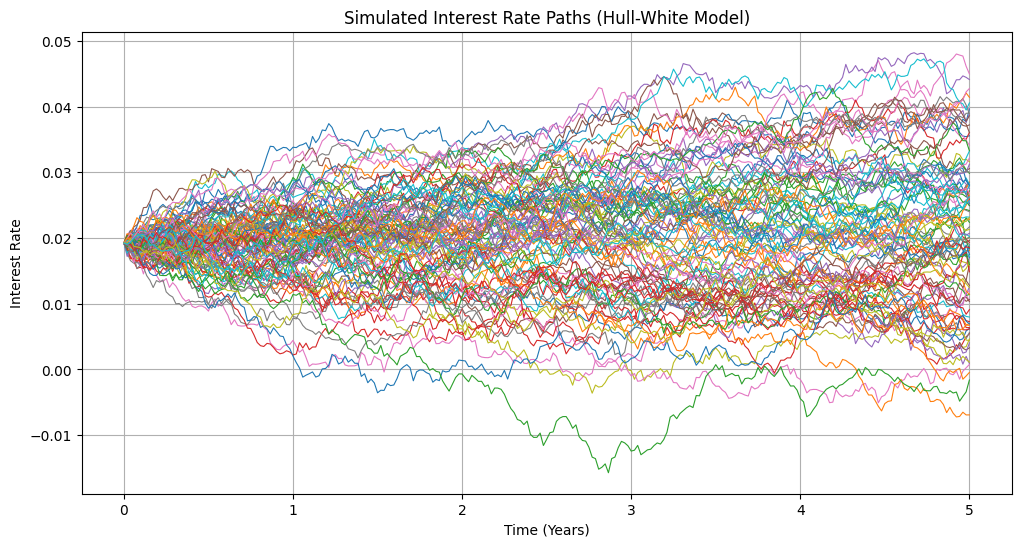

In [500]:

time_steps = 52  # Number of time steps in a year
total_years = maturity_years  # Total simulation years
volatility = [0.00562500] * (maturity_years * time_steps + 1)  # Volatility of interest rates (sigma) taken from EUR ESTR ATM Swaption - Normal 50 5Y 3M
# this is typically a non constant in real life but for now I do not want to spend time on the volatility calibration. 
# This can be achieved by calibrating to market interest rate quoted options (caplets, swaptions, floorlets)
dt = 1 / time_steps  # Time step size

# Initialize arrays to store simulated interest rate paths
num_simulations = 1000  # Number of Monte Carlo simulations
interest_rate_paths = np.zeros((num_simulations, total_years * time_steps + 1))

# Set initial interest rate (e.g., current ESTR rate)
initial_rate = 0.01923  # 1.923%
interest_rate_paths[:, 0] = initial_rate

# Simulate interest rate paths using the Hull-White model
np.random.seed(42)  # Set seed for reproducibility
for t in range(1, total_years * time_steps + 1):
    # Generate random normal shocks
    z = np.random.normal(0, 1, num_simulations)
    # Apply the Hull-White model formula
    dr = mean_reversion_speed * (long_term_mean_rate - interest_rate_paths[:, t - 1]) * dt + volatility[t-1] * np.sqrt(dt) * z
    interest_rate_paths[:, t] = interest_rate_paths[:, t - 1] + dr

# Plot a subset of simulated interest rate paths
plt.figure(figsize=(12, 6))
horizon = np.linspace(0, total_years, total_years * time_steps + 1)
for i in range(int(0.10*num_simulations)):  # Plot 100 random paths
    plt.plot(horizon, interest_rate_paths[i, :], lw=0.8)
plt.title("Simulated Interest Rate Paths (Hull-White Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

# Calculate Exposure Profiles
Compute the potential future exposure (PFE) and expected exposure (EE) for the interest rate swap based on the simulated paths.

In [501]:
num_simulations, num_steps = interest_rate_paths.shape 
print(f"Number of simulation = {num_simulations} number of pricing dates per simulation {num_steps}\n")
exposures = np.zeros((num_simulations, num_steps))
discounted_cash_flows = np.zeros((num_simulations, num_steps))
for t in range(1, num_steps):
    # Calculate the floating rate cash flow
    floating_rate_cash_flow = interest_rate_paths[:, t] * notional_amount * payment_frequency
    # Calculate the fixed rate cash flow
    fixed_rate_cash_flow = fixed_rate * notional_amount * payment_frequency
    # Net cash flow (floating - fixed)
    net_cash_flow = floating_rate_cash_flow - fixed_rate_cash_flow
    # Discount the net cash flow to the present value
    discount_factor = np.exp(-fixed_rate*t*dt)
    discounted_cash_flows[:, t] = net_cash_flow * discount_factor
discounted_cash_flows.shape

Number of simulation = 1000 number of pricing dates per simulation 261



(1000, 261)

In [502]:
num_simulations, num_steps = interest_rate_paths.shape 
print(f"Number of simulation = {num_simulations} number of pricing dates per simulation {num_steps}\n")
exposures = np.zeros((num_simulations, num_steps))
for i in range(1, num_steps):
    discounted_cash_flows = np.zeros((num_simulations, num_steps))
    for t in range(i, num_steps):
        # Calculate the floating rate cash flow
        floating_rate_cash_flow = interest_rate_paths[:, t] * notional_amount * payment_frequency
        # Calculate the fixed rate cash flow
        fixed_rate_cash_flow = fixed_rate * notional_amount * payment_frequency
        # Net cash flow (floating - fixed)
        net_cash_flow = floating_rate_cash_flow - fixed_rate_cash_flow
        # Discount the net cash flow to the present value
        discount_factor = np.exp(-fixed_rate*t*dt)
        discounted_cash_flows[:, t] = net_cash_flow * discount_factor
    exposures[:,i] = np.sum(discounted_cash_flows, axis = 1)

Number of simulation = 1000 number of pricing dates per simulation 261



## Plotting the exposures

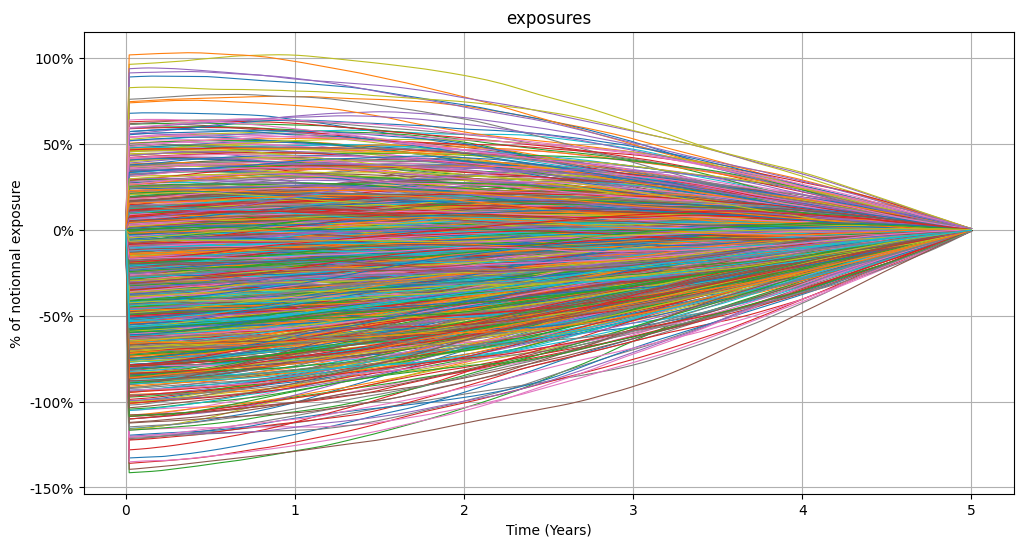

In [503]:
plt.figure(figsize=(12, 6))
horizon = np.linspace(0, total_years, total_years * time_steps + 1)
for i in range(int(num_simulations)):  # Plot 100 random paths
    plt.plot(horizon, exposures[i, :]/notional_amount, lw=0.8)
plt.title("exposures")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlabel("Time (Years)")
plt.ylabel("% of notionnal exposure")
plt.grid(True)
plt.show()

In [504]:
exposures

array([[ 0.00000000e+00,  1.62168739e+05,  1.63179199e+05, ...,
         7.88771034e+03,  5.25502917e+03,  2.64156251e+03],
       [ 0.00000000e+00, -1.29994598e+05, -1.28860366e+05, ...,
        -5.96658321e+02, -3.53007053e+02, -1.84665088e+02],
       [ 0.00000000e+00, -4.64794402e+04, -4.54984084e+04, ...,
         4.20773656e+02,  2.61959936e+02,  1.12939747e+02],
       ...,
       [ 0.00000000e+00, -3.21525477e+05, -3.20543111e+05, ...,
        -6.21525875e+03, -4.06279881e+03, -2.10939836e+03],
       [ 0.00000000e+00, -6.78539020e+04, -6.66352849e+04, ...,
         2.10215746e+03,  1.17949312e+03,  6.35197927e+02],
       [ 0.00000000e+00, -5.68219180e+05, -5.67223508e+05, ...,
        -7.90146443e+03, -5.28288585e+03, -2.65465454e+03]],
      shape=(1000, 261))

In [505]:
net_cash_flow.shape

(1000,)

In [506]:
positive_exposures = exposures.copy()
positive_exposures[positive_exposures < 0] = 0
positive_exposures.shape

(1000, 261)

In [507]:
# # Calculate Exposure Profiles

# # Define a function to calculate the discounted cash flows for the interest rate swap
# def calculate_swap_exposure(interest_rate_paths, notional_amount, fixed_rate, dt):
#     num_simulations, num_steps = interest_rate_paths.shape
#     discounted_cash_flows = np.zeros((num_simulations, num_steps))
    
#     for t in range(1, num_steps):
#         # Calculate the floating rate cash flow
#         floating_rate_cash_flow = interest_rate_paths[:, t] * notional_amount * payment_frequency * dt
#         # Calculate the fixed rate cash flow
#         fixed_rate_cash_flow = fixed_rate * notional_amount * payment_frequency * dt
#         # Net cash flow (floating - fixed)
#         net_cash_flow = floating_rate_cash_flow - fixed_rate_cash_flow
#         # Discount the net cash flow to the present value
#         discount_factor = np.exp(-fixed_rate*t*dt)
#         discounted_cash_flows[:, t] = net_cash_flow[:, None] * discount_factor
    
#     return discounted_cash_flows



# Positive exposures

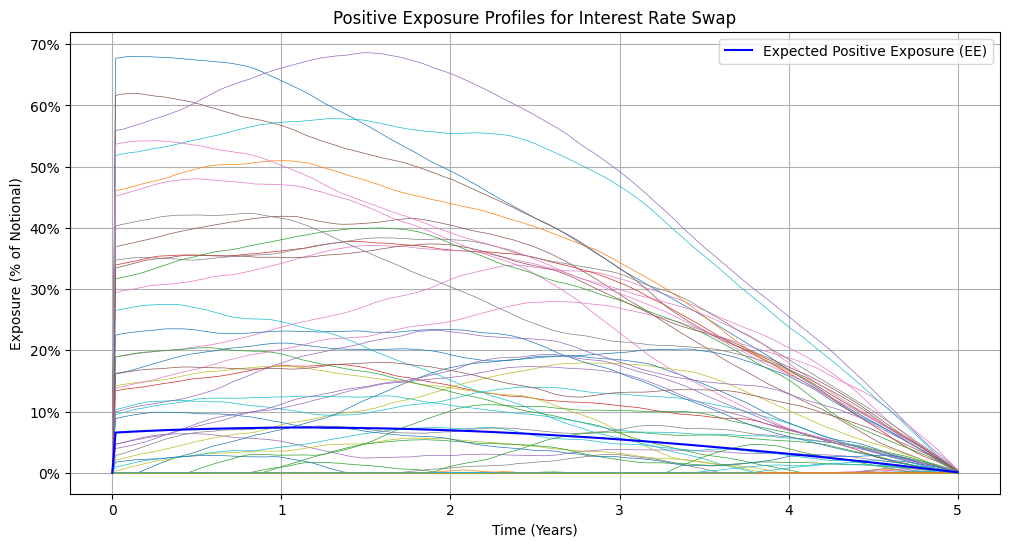

In [508]:
# Calculate the discounted cash flows for the interest rate swap
# discounted_cash_flows = calculate_swap_exposure(interest_rate_paths, notional_amount, fixed_rate, dt)

# # Compute the Potential Future Exposure (PFE) and Expected Exposure (EE)
# pfe = np.percentile(discounted_cash_flows, 95, axis=0)  # 95th percentile
EPE = np.mean(positive_exposures, axis=0)  # Average exposure

# Plot the EPE profile
plt.figure(figsize=(12, 6))
# time_grid = np.linspace(0, total_years, total_years * time_steps + 1)
# plt.plot(time_grid, pfe, label="Potential Future Exposure (PFE)", color="red")
for i in range(int(100)):  # Plot 100 random paths
    plt.plot(horizon, positive_exposures[i, :]/notional_amount, lw=0.5)
plt.plot(horizon, EPE/notional_amount, label="Expected Positive Exposure (EE)", color="blue")
plt.title("Positive Exposure Profiles for Interest Rate Swap")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlabel("Time (Years)")
plt.ylabel("Exposure (% of Notional)")
plt.legend()
plt.grid(True)
plt.show()

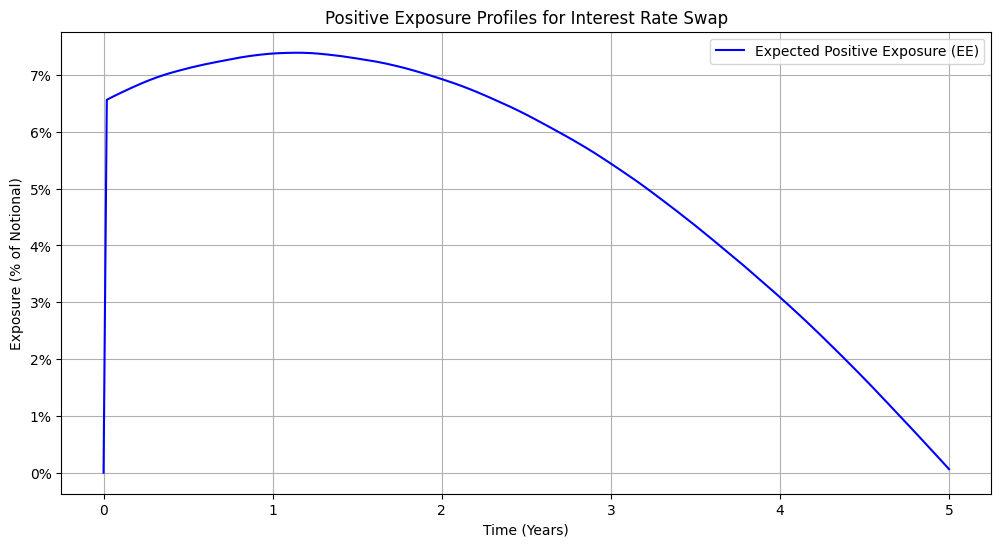

In [509]:
# Plot the EPE profile
plt.figure(figsize=(12, 6))
# time_grid = np.linspace(0, total_years, total_years * time_steps + 1)
# plt.plot(time_grid, pfe, label="Potential Future Exposure (PFE)", color="red")
plt.plot(horizon, EPE/notional_amount, label="Expected Positive Exposure (EE)", color="blue")
plt.title("Positive Exposure Profiles for Interest Rate Swap")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlabel("Time (Years)")
plt.ylabel("Exposure (% of Notional)")
plt.legend()
plt.grid(True)
plt.show()

In [510]:
# # plt.figure(figsize=(12, 6))
# for i in range(1000):
#     plt.plot(horizon,discounted_cash_flows[i,:],)
# plt.title("Simulated Discounted Cashlows")
# plt.xlabel("Time (Years)")
# plt.ylabel("Discounted Cashflows")
# plt.grid(True)
# plt.show()

# Compute CVA

CVA is calculated as the discounted sum of expected positive exposure (EPE) 
multiplied by the counterparty's probability of default (PD) and loss given default (LGD).

$$
CVA = LGD \times \sum_{t=0}^{T}EPE(t)\times PD(t|\text{counterparty hasn't defaulted})
$$

In [511]:
# Compute xVA Metrics

def calculate_cva(EPE, counterparty_pd, counterparty_lgd, dt):
    cva = np.sum(EPE * counterparty_pd * counterparty_lgd * dt)
    return cva

# Define parameters for xVA calculations
counterparty_pd = 0.01  # Counterparty probability of default per year
counterparty_lgd = 0.6  # Counterparty loss given default (60%)

cva = calculate_cva(EPE, counterparty_pd, counterparty_lgd, dt)

print("xVA Metrics:")
print(f"Credit Valuation Adjustment (CVA): ${cva:,.2f}")

xVA Metrics:
Credit Valuation Adjustment (CVA): $1,587.66
